<span style="font-family:Papyrus; font-size:3em;">Analysis of Fitting Surfaces</span>

# Preliminaries

In [1]:
from src.surface_analyzer import SurfaceAnalyzer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import tellurium as te
import pandas as pd
import seaborn as sn

In [2]:
NRMSE = "nrmse"  # Normalized root of the mean square error (residuals)

# One Species Pathway

Consider the pathway $X0 \xrightarrow{k_1} x \xrightarrow{k_2} X_1$, where $X_0$ and $X1$ have fixed concentrations and reactions kinetics
are mass action with kinetic constants $k_i$.
Then, $\frac{dx}{dt} = k_1 X_0 - k_2 x$.
We want to explore the fitting surface for $k_1, K_2$.

In [3]:
MODEL = """

J1: $X0 -> x; k1*X0
J2: x -> $X1; k2*x

X0 = 1
x = 0
k1 = 1
k2 = 1
"""

In [4]:
PARAMETER_DCT = {"k1": 1, "k2": 2}

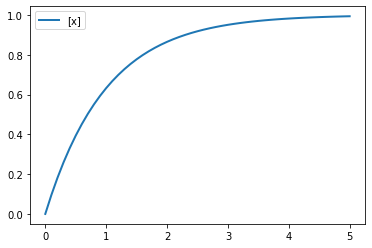

In [5]:
rr = te.loada(MODEL)
trueData = rr.simulate()
rr.plot(trueData)

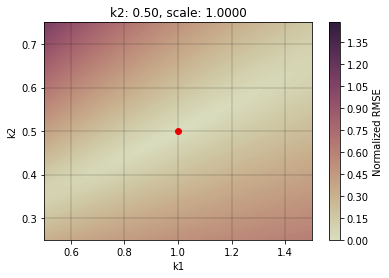

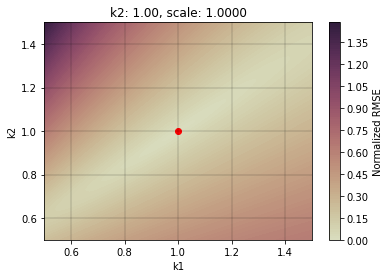

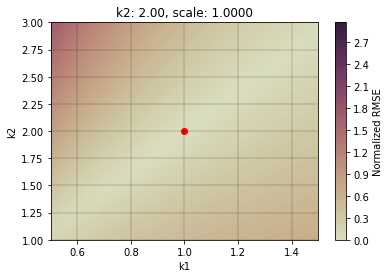

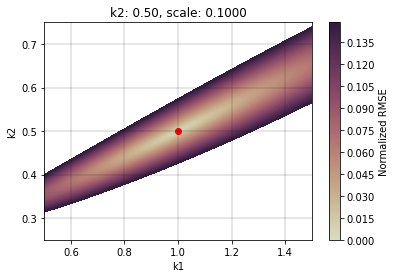

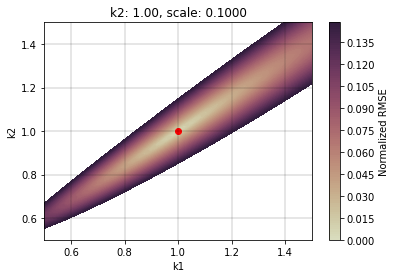

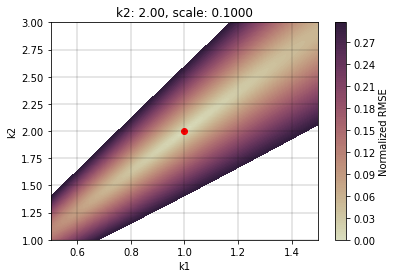

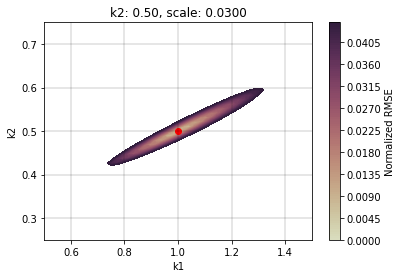

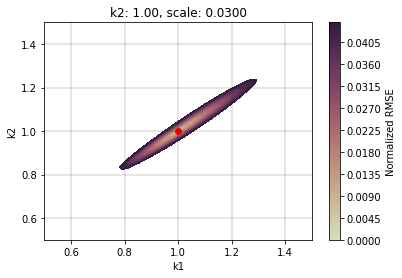

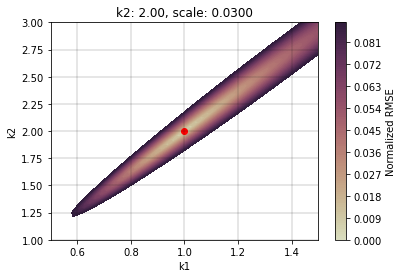

In [6]:
analyzer = SurfaceAnalyzer(MODEL, PARAMETER_DCT)
scales = [1, 0.1, 0.03]
k2s = [0.5, 1.0, 2.0]
for scale in scales:
    for k2 in k2s:
        parameterDct = dict(PARAMETER_DCT)
        parameterDct["k2"] = k2
        analyzer = SurfaceAnalyzer(MODEL, parameterDct)
        analyzer.runExperiments(0.5, 50)
        title = "k2: %2.2f, scale: %2.4f" % (k2, scale)
        analyzer.plotSurface(scale=scale, title=title)

**observations**
1. Convex surface
1. Lower values on line with slope $k_1 / k_2$.
1. Steeper slope for minima for $k_2$ compared with $k_1$.

# Analysis for One Species

**Result**: Parameter fitting for a one species system is a convex optimization.
Given observational data $y(t)$ for a one species system and $t_{ss}$ such that
$y(t) = x_{ss}$ for $t \geq t_{ss}$.
Let $x(t; k_1, k_2)$ be the system with parameters $k_1, k_2$ and
$k_1^{\star}, k_2^{\star}$ such that $y(t) = x(t; k_1^{\star}, k_2^{\star})$.
We claim that $k_1^{\star}, k_2^{\star}$ are the solution to the following convex optimization:
minimize $\sum_t \left( y(t) - x(t; k_1, k_2) \right) ^2$ such that $\frac{k_1}{k_2} = x_{ss}$.

**Problem setup**
1. The one species system with a constant input $X_0$ and initial condition $x(0)=0$ has the solution.
$x(t) = X_0 \frac{k_1}{k_2}(1 - e^{-k_2 t})$. **[Generalize to non-zero initial conditions]**

1. The residuals are $r(t) =  y(t) - x(t; k_1, k_2) = x(t; k_1^{\star}, k_1^{\star}) - x(t; k_1, k_2)$

1. The sum of squares of the residuals is $R_{SSQ} = \int_0^{\infty} r(t)^2 dt$.


**Analysis for $\frac{k_1}{k_2} = \frac{k^{\star}_1}{k^{\star}_2}$**
1. $r(t) =  A( -e^{-k_2 t} + e^{-k^{\star}_2 t})$, where $A = X_0 \frac{k_1^{\star}}{k_2^{\star}}$.

1. $R_{SSQ} = A^2 \int_0^{\infty} \left( e^{-2k_2 t} -2 e^{-(k_2 + k^{\star}_2)t} + e^{-2k^{\star}_2t} \right)$

1. And so, $R_{SSQ} = A^2 \left( - \frac{1}{2k_2} e^{-2k_2 t} +  \frac{2}{k_2 + k^{\star}_2} e^{-(k_2 + k^{\star}_2)t} - \frac{1}{2k^{\star}_2} e^{-2k^{\star}_2t} \right) \biggr\vert_0^{\infty}$

1. $R_{SSQ} = A^2 \left( \frac{1}{2k_2} -  \frac{2}{k_2 + k^{\star}_2} + \frac{1} {2 k^{\star}_2}  \right)$


In the sequel, we simplify notation by using
$g(u; u^{\star}) = \frac{1}{2 u^{\star}} -  \frac{2}{u + u^{\star}} + \frac{1} {2 u}$, for $u, u^{\star} > 0$.

**Claim:** Given $g(u; u^{\star})$ as defined above:
1. $g(u; u^{\star})$ is positive semidefinite.
1. $g(u; u^{\star}) = 0$ iff $u = u^{\star}$
1. $u^{\star}$ is the solution to a convex optimization.

**Proof:**
The first two claims are established by the following:
$
g(u; u^{\prime})  \geq  0 \equiv u(u + u^{\star}) - 4 u u^{\star} + u^{\star} (u + u^{\star}) \geq 0
\equiv (u - u^{\star}) ^ 2 \geq 0$.
The third claim follow from the fact that minimizing $g(u; u^{\prime})$ is equivalent to solving a convex optimization.

**Claim**: $R_{SSQ}$ is convex in $k^{\star}_2$. **[This may be unnecessary.]**

1. Claim that $\frac{\partial T_{SE}}{\partial k^{\star}} \geq 0$.

1. Note that $\frac{\partial^2 R_{SSQ}}{\partial^2 k^{\star}_2} 
= A^2 \left( \frac{1}{k^3_2} -  \frac{4 }{(k_2 + k^{\star}_2)^3} + \frac{1} {( k^{\star}_2)^3}  \right)$

1. Suffices to show that $ \left( \frac{1}{k^3_2} -  \frac{4 }{(k_2 + k^{\star}_2)^3} + \frac{1} {( k^{\star}_2)^3}  \right) \geq 0$

1. Equivalent to  $(k^{\star}_2)^3  (k^{\star}_2 + k_2)^3 -  4 k^3_2 (k^{\star}_2)^3  + k^3_2 (k^{\star}_2 + k_2)^3 \ge0$.
Let $x = k_2$ and $y = x^{\star}_2$. Then, we have
$x^3 (x + y)^3 -4 x^3 y^3 + y^3 (x + y)^3 \geq 0$, where $x, y > 0$.

$
\begin{align}
T & = & x^3 (x^3 + 3x^2y + 3xy^2 + y^3) - 4 x^3 y^3 + y^3 (x^3 + 3x^2y + 3xy^2 + y^3)  \\
& = & x^3 (x^3 + 3x^2y + 3xy^2) - 2 x^3 y^3 + y^3 ( 3x^2y + 3xy^2 + y^3)   \\
 & = & \left( x^3 - y^3 \right) ^2 + 6x^2y + 6 x y^2 \\
 & \ge 0
\end{align}
$

# Notes

1. Objectives
   1. Research - relate that nature of the fitting surface to the chemical network. Show in which cases the fitting surface is convex. Provide insights into strategies for fitting.
   1. Teaching - provide insights into what is happening with the different fitting algorithms by animating their steps.
   
1. Research directions
   1. Fitting surfaces by network type: linear, branched, feedback.
   1. Preliminary insights
      1. Detecting easily fit networks
      1. When do starting positions matter. For which parameters (because of combinatorics). How narrow parameter ranges (to reduce combinatorics).
      
1. A strategy for a linear chain (and maybe more general networks) is to first optimize the ratio of species concentrations.
But which ratios?

1. To do
    1. Show simulations for different points in the curve, relating the simulation results to $R^2$.
    1. Look at longer linear chains.
    1. Examine Wolf model